In [84]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas


n = 300
v = linspace(0.01,800.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True) # Sausage

2.950252041939505
5.0535715269188985


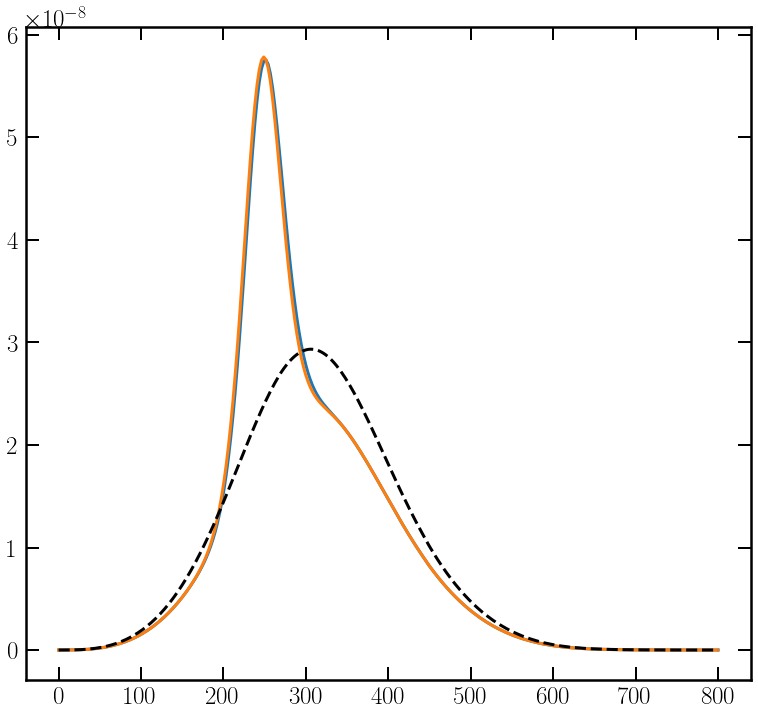

In [106]:
day = 200

fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True) # Sausage

v_S2 = velocities[2,:]
sig_S2 = dispersions[2,:]
eta_saus = 0.2

def fS2(sig,day):
    if size(sig)==3:
        f = SpeedDist_Triaxial(v,day,sig,v_shift=v_S2)
    else:
        f = SpeedDist_Isotropic(v,day,sig=sig,v_shift=v_S2)
    return f 
   
def fmix(xi,sig,day):
    fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
    fvS2 = fS2(sig,day)
    return (1-xi)*fv0+xi*fvS2

def RS(xi,sig,day):
    fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
    R0 = trapz(fv0**2.0/v,v)**(-0.25)
    R1 = trapz(fmix(xi,sig,day)**2.0/v,v)**(-0.25)
    return 100*(1-R1/R0)


fig,ax = MySquarePlot()


xi = 0.1
plt.plot(v,fmix(xi,sig_S2,day)**2.0/v,'-',lw=3)
plt.plot(v,fmix(xi,25.0,day)**2.0/v,'-',lw=3)
plt.plot(v,fmix(0.0,sig_S2,day)**2.0/v,'k--',lw=3)


print(RS(0.1,sig_S2,day))
print(RS(0.1,10.0,day))

plt.show()

# n_xi = 10
# xi_max = 0.1
# xi_vals = linspace(0.0,xi_max,n_xi)

# fvs_lab = sum(fv_lab,0)

# xi_S2 = 0.9
# fvnS2 = sum(fv_lab[3:,:],0)+fv_lab[0,:]
# fvnS2 /= trapz(fvnS2,v)
# fvS2 = fv_lab[1,:]+fv_lab[2,:]
# fvS2 /= trapz(fvS2,v)
# fvS2 = xi_S2*fvS2+(1-xi_S2)*fvnS2

# def RSdef(fvs_lab):
#     fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
#     R0 = trapz(fv0**2.0/v,v)**(-0.25)
#     RS = zeros(shape=n_xi)
#     for i in range(0,n_xi):
#         xi = xi_vals[i]
#         fv1 = (((1-eta_saus-xi)*fv_Iso_lab + eta_saus*fv_Saus_lab + xi*fvs_lab))
#         R1 = trapz(fv1**2.0/v,v)**(-0.25)
#         RS[i] = 100*(1-R1/R0)



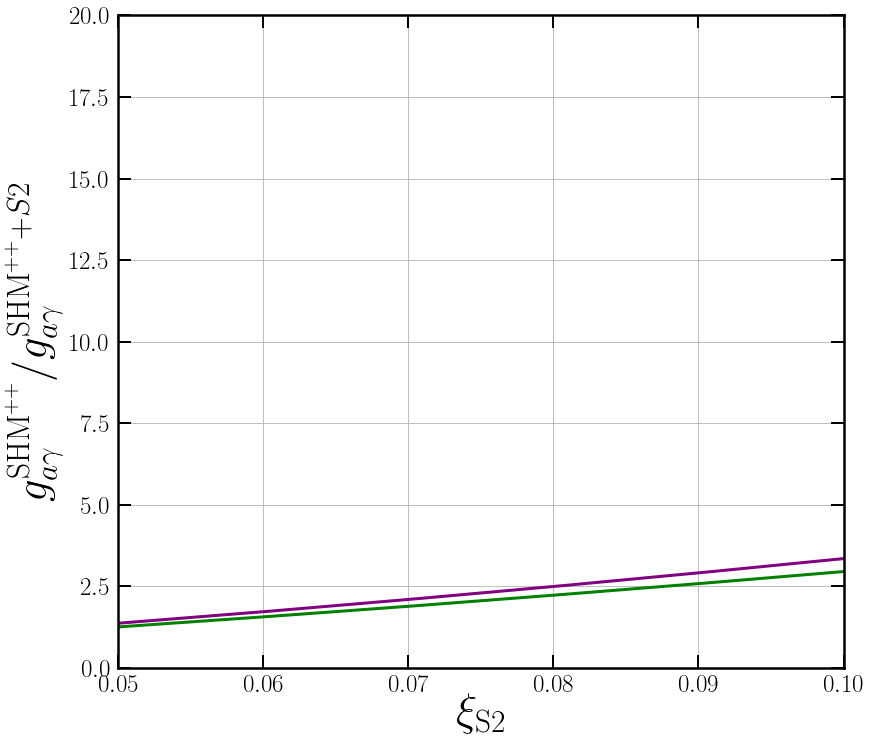

In [111]:
day = 200

def RSrange(xi_vals,sig):
    n_xi = size(xi_vals)
    RS = zeros(shape=n_xi)
    
    fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
    if size(sig)==3:
        fv1 = SpeedDist_Triaxial(v,day,sig,v_shift=v_S2)
    else:
        fv1 = SpeedDist_Isotropic(v,day,sig=sig,v_shift=v_S2)
        
    R0 = trapz(fv0**2.0/v,v)**(-0.25)
    
    for i in range(0,n_xi):
        fv = xi_vals[i]*fv1 + (1-xi_vals[i])*fv0
        R1 = trapz(fv**2.0/v,v)**(-0.25)
        RS[i] = 100*(1-R1/R0)
    return RS


fig,ax = MySquarePlot(r'$\xi_{\rm S2}$',r'$g^{{\rm SHM}^{++}}_{a\gamma}/g^{{\rm SHM}^{++}+S2}_{a\gamma}$')

n_xi = 100
xi_max = 1.0
xi_vals = linspace(0.0,xi_max,n_xi)

plt.plot(xi_vals,RSrange(xi_vals,sig_S2),'g-',lw=3)
plt.plot(xi_vals,RSrange(xi_vals,sig_S2*0.8),'-',color='purple',lw=3)

#plt.yscale('log')
plt.ylim([0,20])
plt.xlim([0.05,0.1])
plt.grid()
plt.show()

In [82]:
n_xi = size(xi_vals)
RS = zeros(shape=n_xi)

fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
fv1 = SpeedDist_Triaxial(v,day,sig_S2,v_shift=v_S2)

R0 = trapz(fv0**2.0/v,v)**(-0.25)

for i in range(0,n_xi):
    fv = xi_vals[i]*fv1 + (1-xi_vals[i])*fv0
    R1 = trapz(fv/v,v)**(-0.25)
    RS[i] = R0/R1

In [48]:
i = 0
fv = xi_vals[i]*fv1 + (1-xi_vals[i])*fv0
R1 = trapz(fv/v,v)**(-0.25)

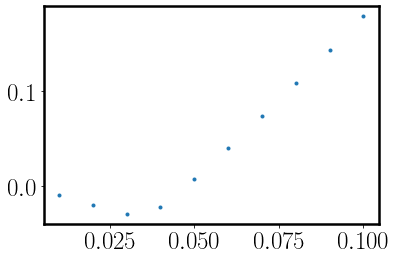

In [138]:
n = 300
v = linspace(0.01,500.0,n)


fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True) # Sausage

def fS2(sig,day):
    if size(sig)==3:
        f = SpeedDist_Triaxial(v,day,sig,v_shift=v_S2)
    else:
        f = SpeedDist_Isotropic(v,day,sig=sig,v_shift=v_S2)
    return f 

def fmix(xi,sig,day):
    fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
    fvS2 = fS2(sig,day)
    return (1-xi)*fv0+xi*fvS2


fv0 = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))


n_xi = 10
xi_vals = linspace(0.01,0.1,n_xi)
x = zeros(shape=n_xi)
for i in range(0,n_xi):
    
    x[i] = (amax(fmix(xi_vals[i],sig_S2,day))-amax(fv0))/amax(fv0)
    
plt.plot(xi_vals,x,'.')

plt.show()

In [139]:
(amax(fmix(0.05,sig_S2,day))-amax(fv0))/amax(fv0)

0.008075592516738546

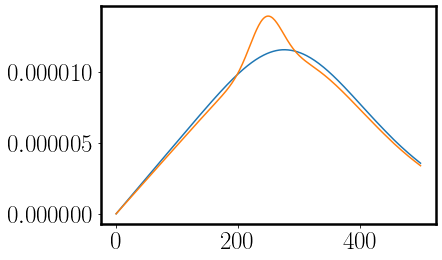

In [153]:
fvS2 = fS2(sig_S2,day)
fvHalo = (((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))

xi = 0.05
fv1 = (1-xi)*fvHalo+xi*fvS2
fv0 = fvHalo


plt.plot(v,fv0/v,'-')
plt.plot(v,fv1/v,'-')

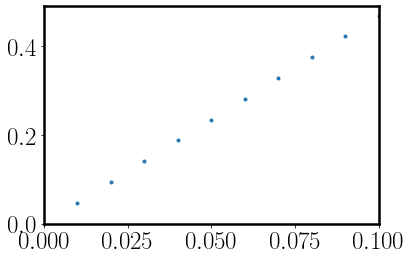

In [160]:



n_xi = 10
xi_vals = linspace(0.01,0.1,n_xi)
x = zeros(shape=n_xi)
for i in range(0,n_xi):
    xi = xi_vals[i]
    fv1 = (1-xi)*fvHalo+xi*fvS2
    x[i] = amax((fv1-fv0)/fv0)
    
plt.plot(xi_vals,x,'.')
plt.xlim([0,0.1])
plt.ylim(bottom=0.0)

plt.show()

In [161]:
xi = 0.05
fv1 = (1-xi)*fvHalo+xi*fvS2
amax((fv1-fv0)/fv0)

0.2343755683630304

In [163]:
(100/0.23)**2.0/(3600)

52.50997689561015